# <center>Fake News Detection Model

<img src="Fake-news-el-peligro-de-la-desinformacion.jpg" width=817 height=510 />

## Introduction

For my final project as part of the Data Science Bootcamp (The Bridge), I have chosen to make a prediction model to see if news is fake or real. With this project I want to put into practise my knowledge of Deep Learning, in specifically focusing on Natural Language Processing (NLP).

The data I will be using in this project is a fake and real news dataset from Kaggle (Source: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset)


The resources of the data is described as following:
The data was collected from realworld sources; the truthful articles were obtained by crawling articles from Reuters.com (News website). As for the fake news articles, they were collected from different sources. The fake news articles were collected from unreliable websites that were flagged by Politifact (a fact-checking
organization in the USA) and Wikipedia. The dataset contains different types of articles on different
topics, however, the majority of articles focus on political and World news topics (Source: https://www.uvic.ca/engineering/ece/isot/assets/docs/ISOT_Fake_News_Dataset_ReadMe.pdf)

Defenition of columns used in the dataset:
- Title: The title of the article
- Text: The text of the article
- Subject: The subject of the article
- Date: The date at which the article was posted

## Method of working

1. Collecting the data
2. Data wrangling and cleaning
3. Studying and visualizing the data
4. Preparing data
5. Building model and Hyperparameter Tuning
6. Training the model
7. Evaluating model
9. Making predictions
10. Conclusions


Importing the necessary libraries:

In [160]:
os.path.abspath('')
root_path = os.path.dirname(os.path.abspath(''))
sys.path.append(root_path)

import pandas as pd 
import numpy as np
import os, sys
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk

import plotly.offline as pyoff
import plotly.graph_objs as go

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.metrics import classification_report, accuracy_score

import gensim

from src.Utils.apis_tb import *
from src.Utils.mining_data_tb import *
from src.Utils.visualization_tb import *

#nltk.download('stopwords')
#nltk.download('punkt')

### 1. Collecting Data

In [36]:
#importing data for fake and real news from Kaggle

fake_news = pd.read_csv(root_path + "\\Resources\\Fake.csv")
real_news = pd.read_csv(root_path + "\\Resources\\True.csv")

In [3]:
fake_news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [4]:
real_news.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

### 2. Data wrangling and cleaning

As we can see from the preview of the data above it looks like data is already ready to use and there is no further data wrangling necessary. We will only need to merge the two dataframes together for further usage as a Train dataset in upcoming steps in the project. 

In order to see if the data needs cleaning before proceeding to the next step, I will make the following steps:

 - Checking the types of the columns.

 - Checking the data for any Nan values.

 - Checking for duplicates in the data

In [37]:
#merging both dataframes together

fake_news['category'] = 0
real_news['category'] = 1
total_news = pd.concat([real_news,fake_news])

In [6]:
#checking column types. All of the columns have Dtype as object. This seems to be correct for columns 0 to 2, but for column 3: Date, we might need to consider changing this to DateTime. 
 
total_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


No data with null values:


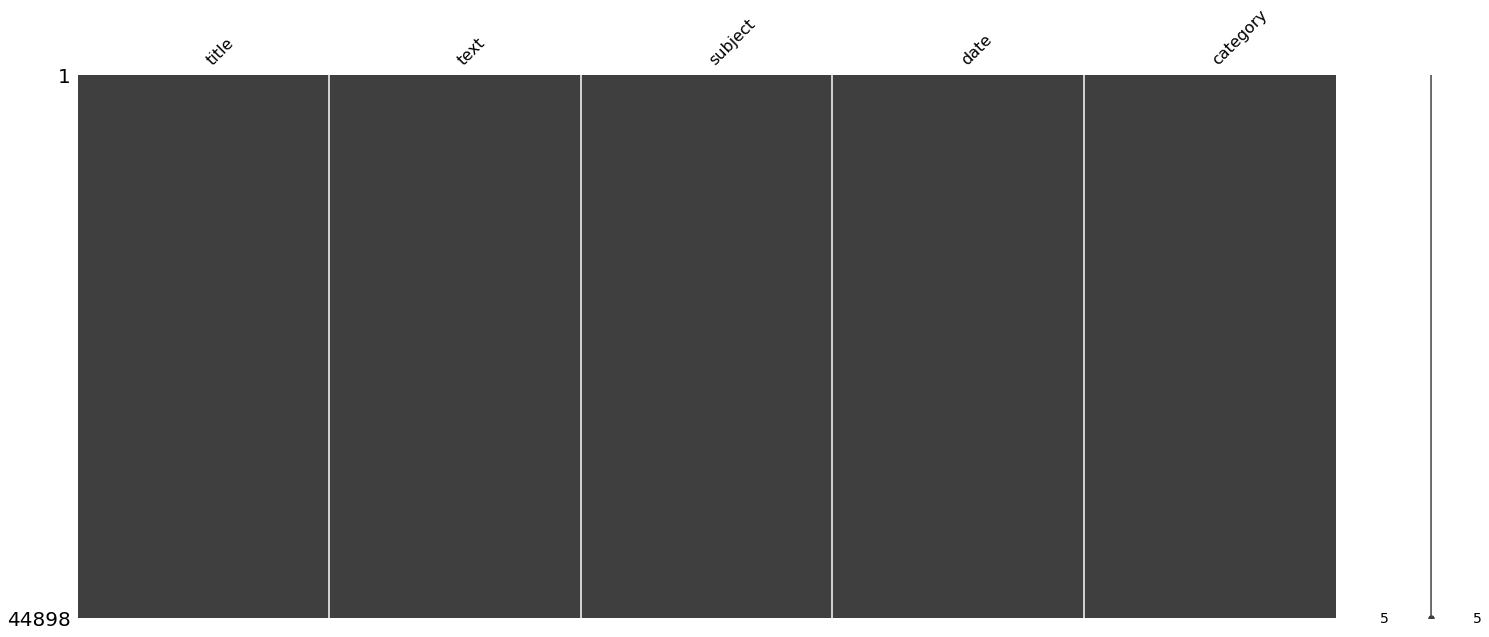

In [7]:
#Checking NaN values of the dataset. Any white spots indicate missing data. In our case there is no missing data.

none_values(df=total_news)

In [8]:
#Running dataframes through function to show the duplicates. We can see there are 209 duplicated rows. 
show_duplicates(df=total_news)


***Number of duplicated entries:  209


title  \
4435   'Nuclear option' fallout? More extreme U.S. ju...   
4439   'Nuclear option' fallout? More extreme U.S. ju...   
11702  After U.S. veto, U.N. General Assembly to meet...   
11798  After U.S. veto, U.N. General Assembly to meet...   
3244   Another U.S. appeals court refuses to revive T...   

                                                    text       subject  \
4435   WASHINGTON (Reuters) - A Republican-backed Sen...  politicsNews   
4439   WASHINGTON (Reuters) - A Republican-backed Sen...  politicsNews   
11702  UNITED NATIONS (Reuters) - The 193-member Unit...     worldnews   
11798  UNITED NATIONS (Reuters) - The 193-member Unit...     worldnews   
3244   SAN FRANCISCO/WASHINGTON (Reuters) - President...  politicsNews   

                     date  category  
4435       April 6, 2017          1  
4439       April 6, 2017          1  
11702  December 19, 2017          1  
11798  December 19, 2017          1  
3244       June 12, 2017          1

In [9]:
#We will drop the duplicated values. I will do this for all three of the dataframes: total_news, fake_news and real_news, in case we need to use either of them later on.

total_news = total_news.drop_duplicates()
real_news = real_news.drop_duplicates()
fake_news = fake_news.drop_duplicates()

### 3. Studying and visualizing the data

I will explore both the real and fake news seperately to get to know the data we are working with. But first I will check if the values of both datasets to see if they are balanced:

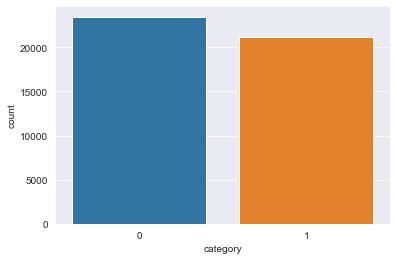

In [10]:
#Data looks pretty balanced.
sns.set_style("darkgrid")
sns.countplot(total_news.category)

#### Exploring data of Fake News

In [11]:
fake_news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  category  
0  December 31, 2017         0  
1  December 31, 2017         0  
2  December 30, 2017         0  
3  December 29, 2017         0  
4  December 25, 2017         0

In [12]:
fake_news.reset_index(drop=True, inplace=True)

In [76]:
#Checking for empty text columns:
list_empty = [index for index,text in enumerate(fake_news.text.values) if str(text).strip() == '']

In [14]:
#Showing the data where text is missing:
fake_news.iloc[list_empty].tail()

title text    subject  \
21813  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...       left-news   
21823  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...       left-news   
21824  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...       left-news   
21854  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...       left-news   
21870  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...       left-news   

               date  category  
21813  Apr 27, 2015         0  
21823  Apr 25, 2015         0  
21824  Apr 25, 2015         0  
21854  Apr 14, 2015         0  
21870  Apr 12, 2015         0

In [15]:
#Removing empty text data
for elem in list_empty:
        fake_news.drop(elem, axis=0, inplace=True)
    

In [16]:
#Having a look at the Subjects columns and counting the values.
for key,count in fake_news.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{fake_news.shape[0]}")

News:	9050
politics:	6430
left-news:	4309
Government News:	1498
US_News:	783
Middle-east:	778
Total Records:	22848


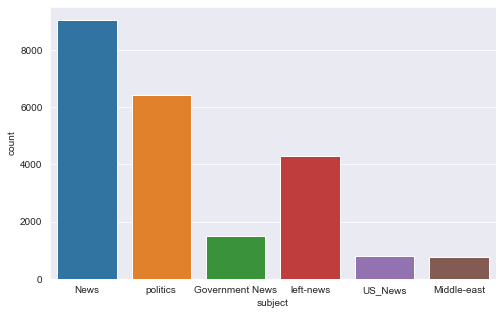

In [17]:
subject_distribution(df=fake_news)

The articles are mostly about news and politics

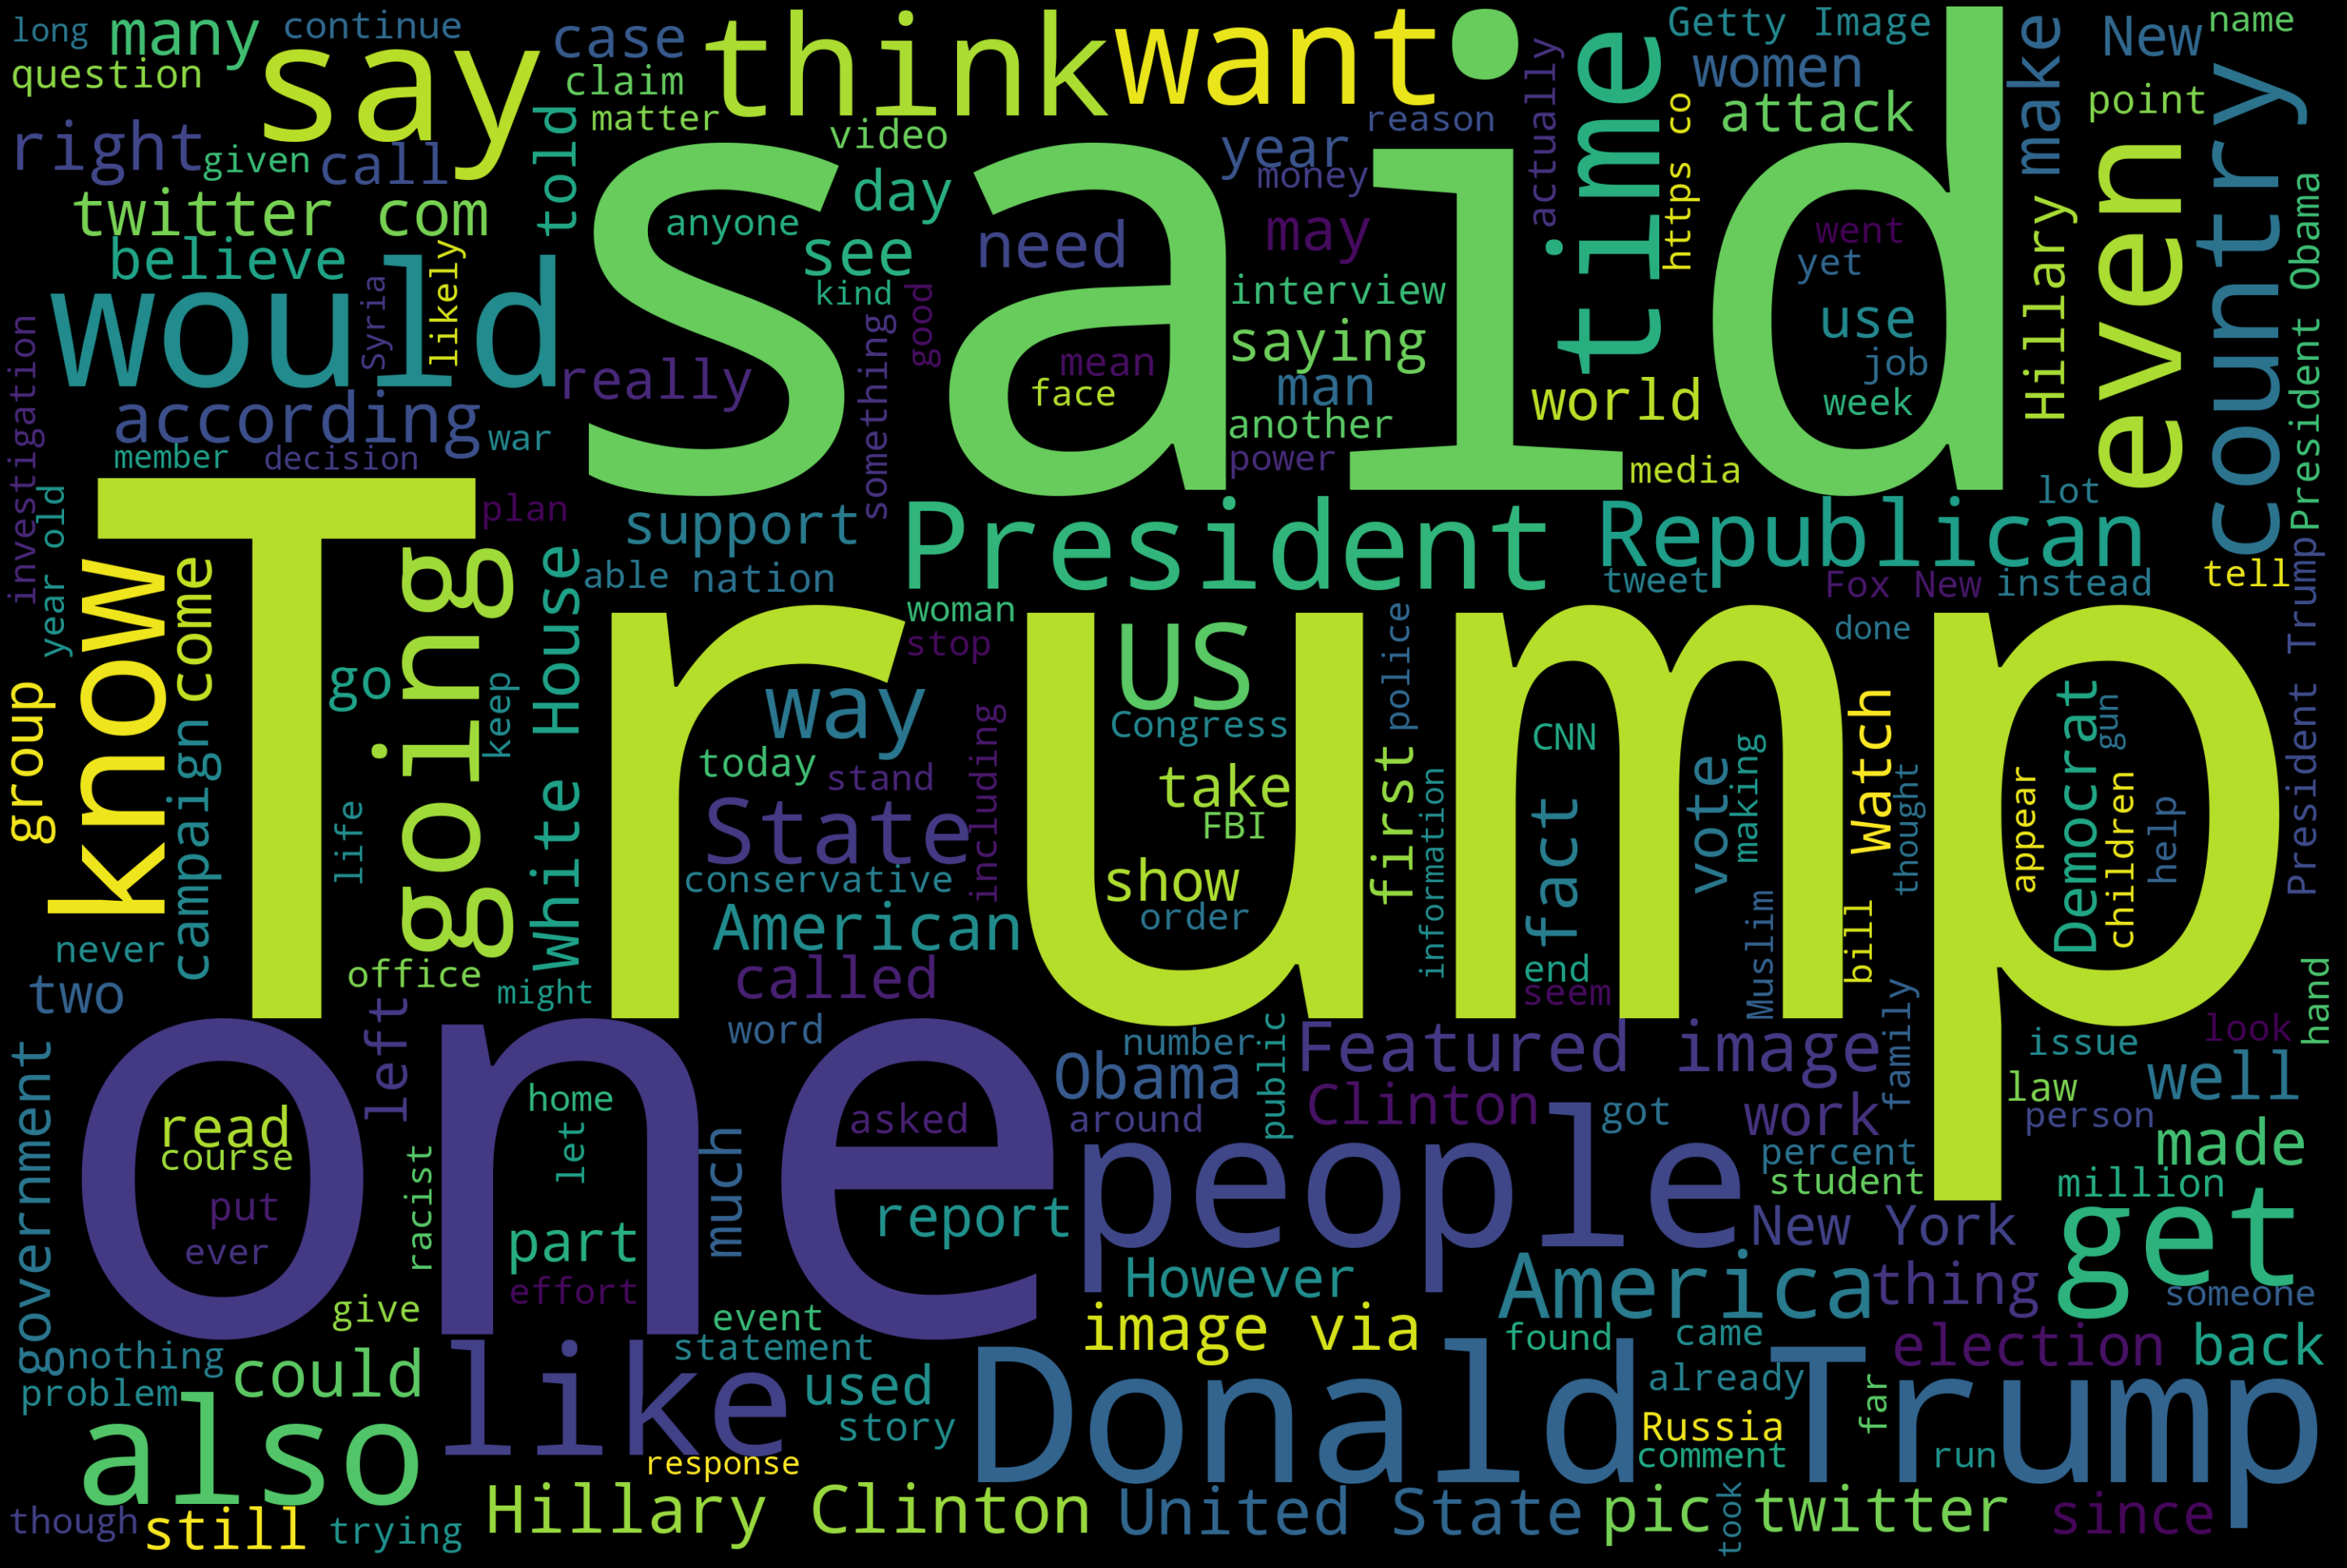

Wall time: 3min 34s


In [73]:
%%time
# Making a word cloud. this is a cloud filled with words of the dataset in different sizes, which represent the frequency or the importance of each word.
show_wordcloud(df=fake_news)

#### Exploring data of Real News

In [18]:
real_news.head(10)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   
5  White House, Congress prepare for talks on spe...   
6  Trump says Russia probe will be fair, but time...   
7  Factbox: Trump on Twitter (Dec 29) - Approval ...   
8         Trump on Twitter (Dec 28) - Global Warming   
9  Alabama official to certify Senator-elect Jone...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
5  WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...  politicsNews   
6  WEST PALM BEACH, Fla (Reuters) - President Don...  politicsNews   
7  The following statements were posted to the ve...  politicsNews   
8  The following statements were posted to the ve...  politicsNews   
9  WASHINGTON (Reuters) - Alabama Secretary of St...  politicsNews   

                 date  category  
0  December 31, 2017          1  
1  December 29, 2017          1  
2  December 31, 2017          1  
3  December 30, 2017          1  
4  December 29, 2017          1  
5  December 29, 2017          1  
6  December 29, 2017          1  
7  December 29, 2017          1  
8  December 29, 2017          1  
9  December 28, 2017          1

There is a difference between the real and fake news dataset: The real news data has extra information in the text column: Reuters. This representens the source information. 

In order to be able to compare the real and fake news correclty, it will be necessary to remove the reuters information from the text column. 

In [19]:
#function to remove publisher information imported from mining_data_tb.py.
real_news = remove_publisher(df=real_news)

In [20]:
real_news.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0   The head of a conservative Republican faction...  politicsNews   
1   Transgender people will be allowed for the fi...  politicsNews   
2   The special counsel investigation of links be...  politicsNews   
3   Trump campaign adviser George Papadopoulos to...  politicsNews   
4   President Donald Trump called on the U.S. Pos...  politicsNews   

                 date  category  
0  December 31, 2017          1  
1  December 29, 2017          1  
2  December 31, 2017          1  
3  December 30, 2017          1  
4  December 29, 2017          1

In [21]:
#Checking for empty text columns:
[index for index,text in enumerate(real_news.text.values) if str(text).strip() == '']

[8924]

In [22]:
#index 8924 has an empty text column and therefore will be removed. 
print(real_news.iloc[8924])
real_news.drop(8970, axis=0, inplace=True)

title       Graphic: Supreme Court roundup
text                                      
subject                       politicsNews
date                        June 16, 2016 
category                                 1
Name: 8970, dtype: object


In [23]:
#Getting Total Rows
print(f"Total Records:\t{real_news.shape[0]}")

#Counting by Subjects 
for key,count in real_news.subject.value_counts().iteritems():
  print(f"{key}:\t{count}")

Total Records:	21210
politicsNews:	11219
worldnews:	9991


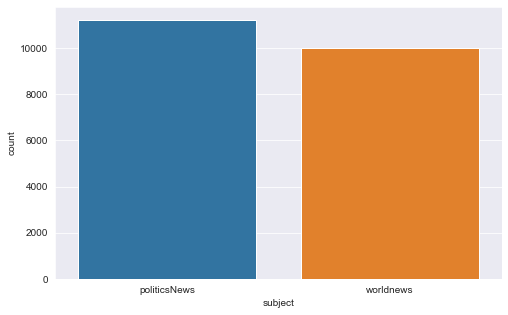

In [24]:
subject_distribution(df=real_news)

The real news dataset has only 2 categories: political news and worldnews. 

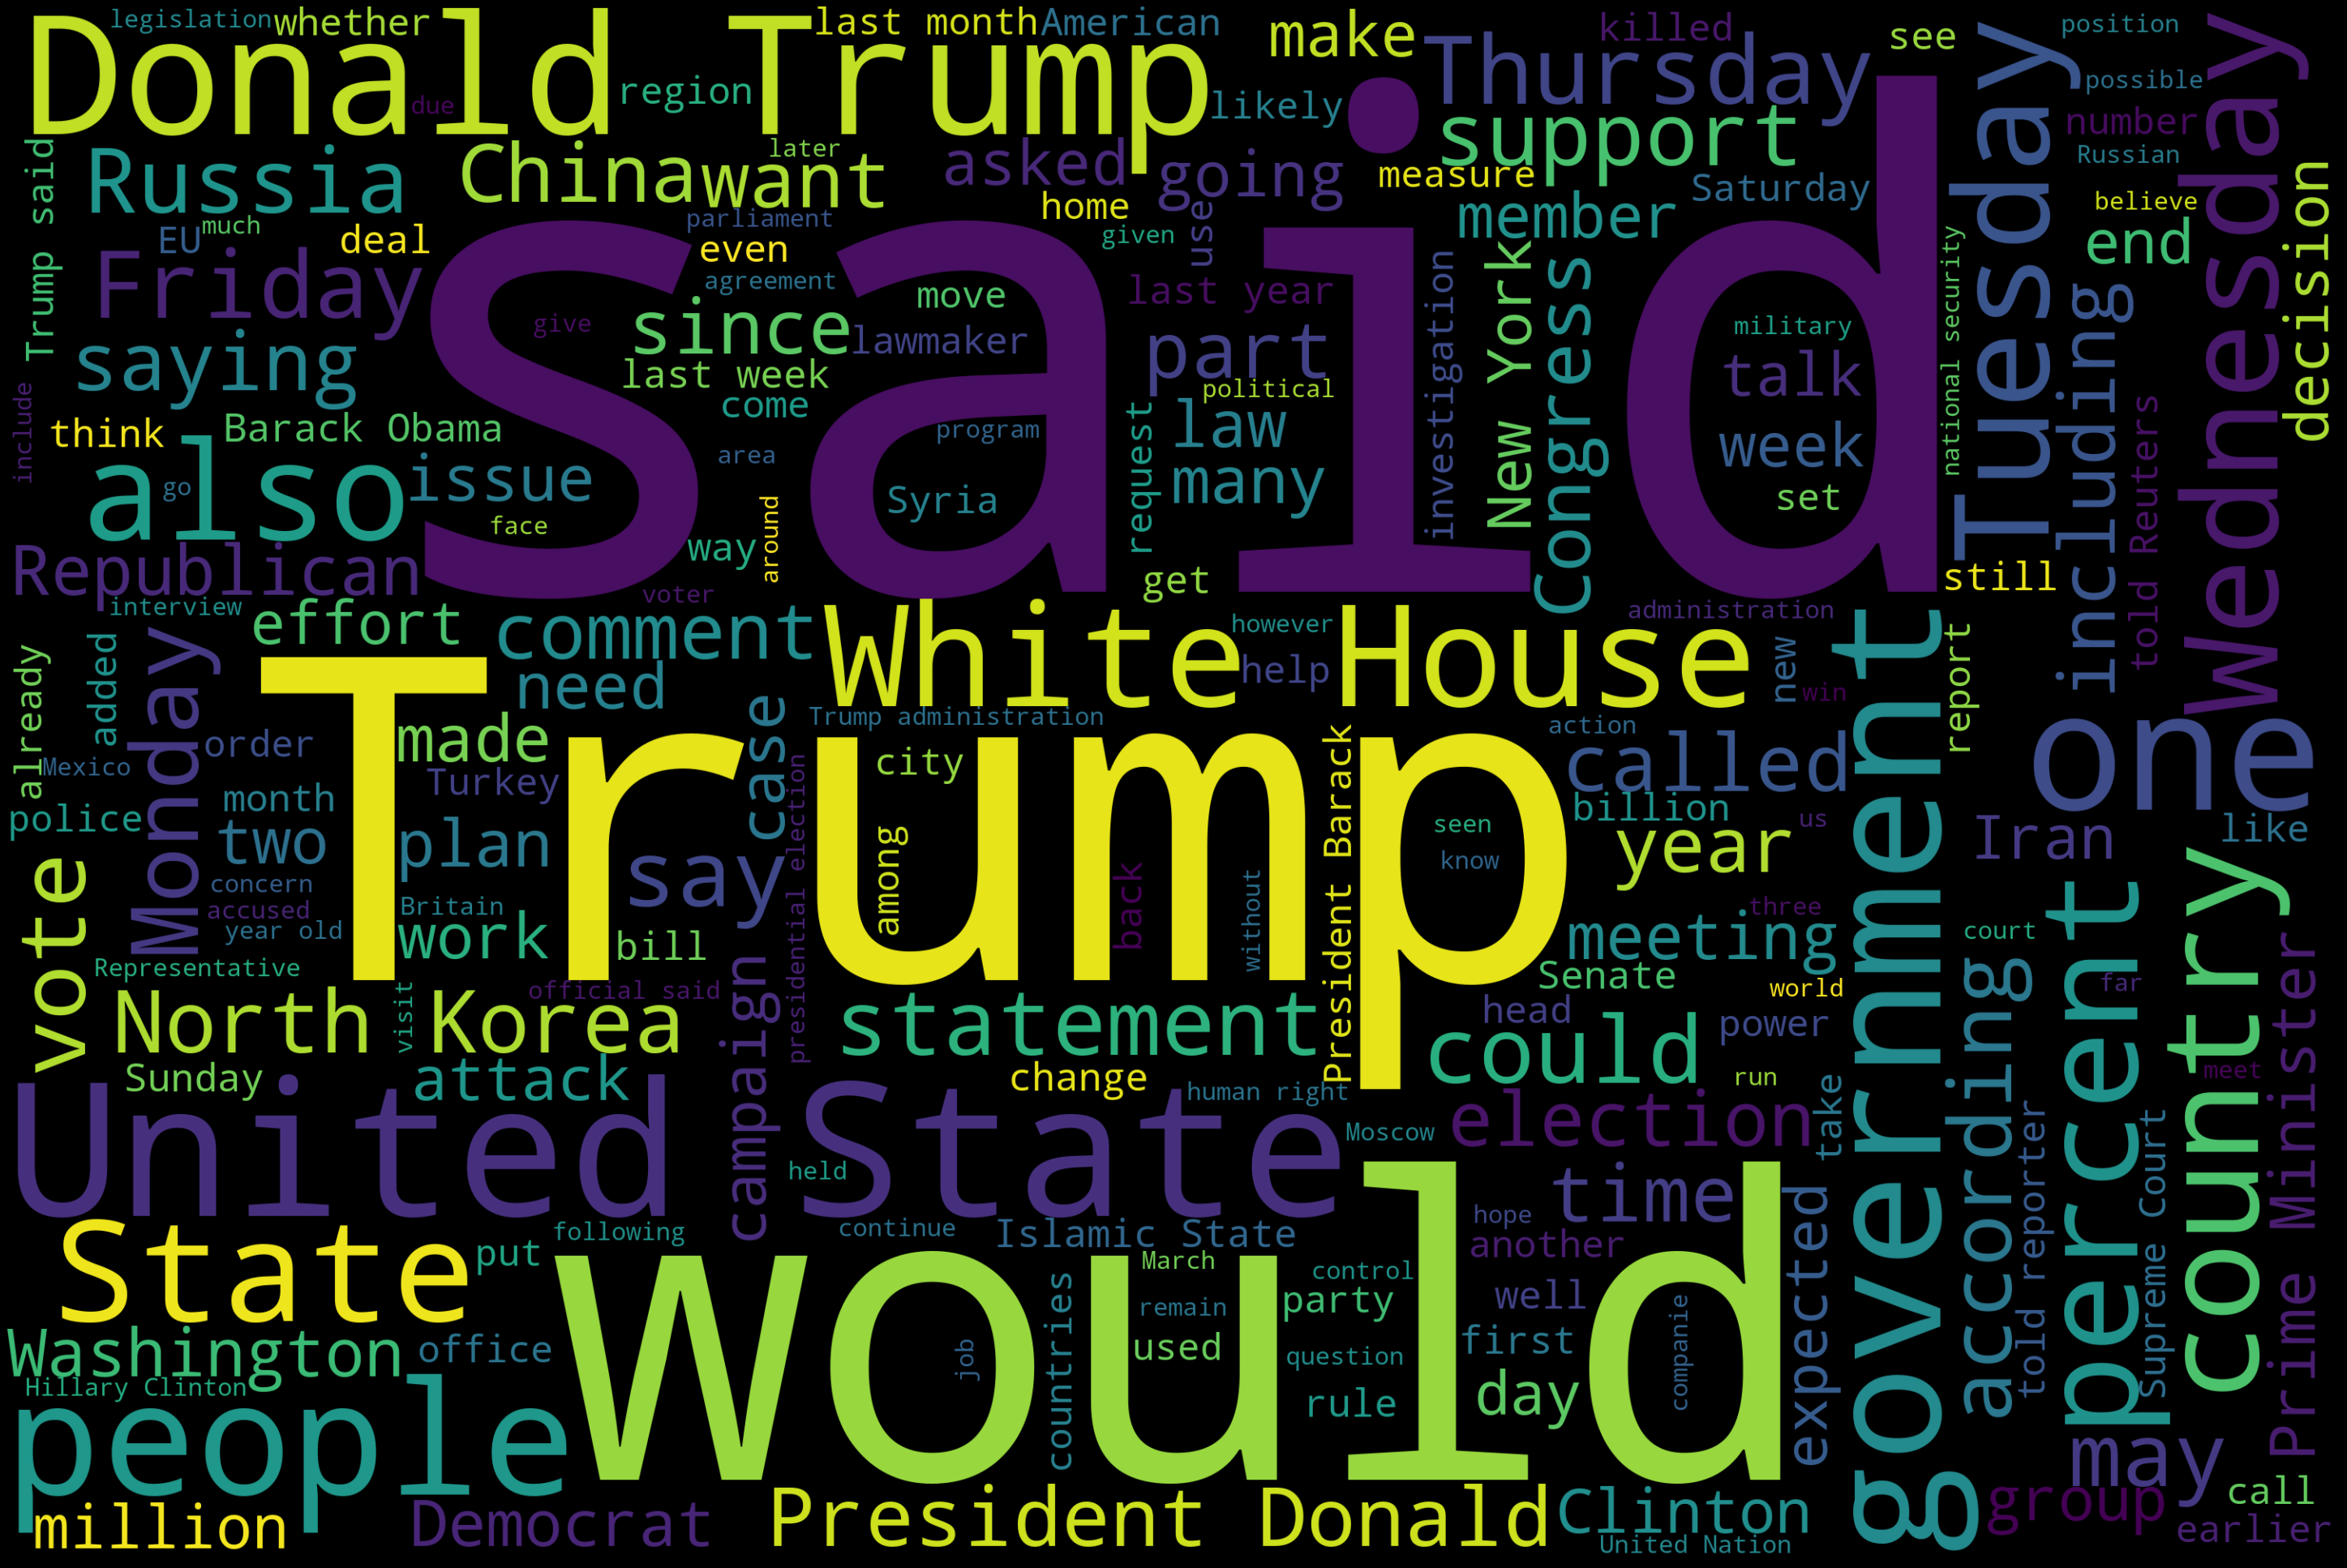

In [72]:
#Wordcloud of real news dataset
show_wordcloud(df=real_news)

#### Exploring data of the combined dataset

In [42]:
## visualizing the time column

df=total_news.copy()
pattern = "Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec"
filter1 = df['date'].str.contains(pattern)
df=df[filter1]
df['date'] = pd.to_datetime(df['date'])

df=df.sort_values(by=['date'])
df=df.reset_index(drop=True)


df_1=df[df['category']==1]
df_1=df_1.groupby(['date'])['category'].count()
df_1=pd.DataFrame(df_1)

df_0=df[df['category']==0]
df_0=df_0.groupby(['date'])['category'].count()
df_0=pd.DataFrame(df_0)

In [47]:
plot_by_time(df_true=df_1, df_false=df_0)

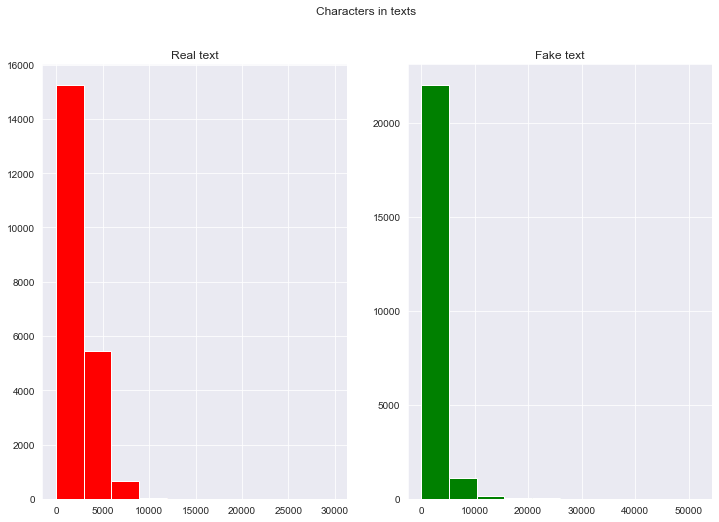

In [56]:
#Comparing characters in the texts of fake news vs real news.
amount_characters(df=total_news)

We can see that fake text usually includes more characters in the text than real news.  0 to 2500 characters in the text is the most common in the text of real news while around 0 to 5000 characters in text are most common in text of the fake news category.

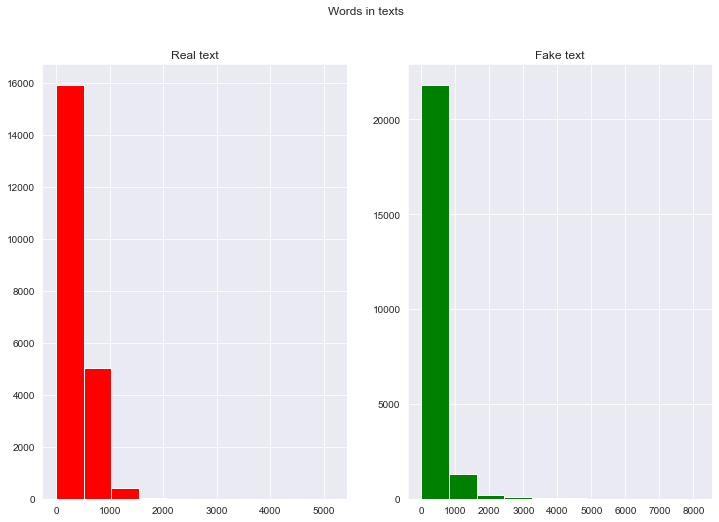

In [54]:
#Comparing amount of words in text of real news vs fake news. 
amount_words(df=total_news)

Again, the text of fake news articles seem to have more words then the real news articles. 

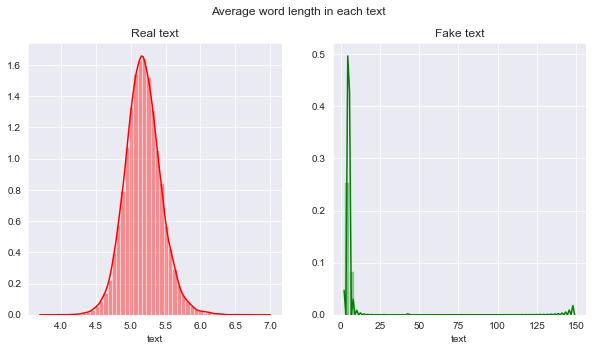

In [59]:
#Comparing average word length:
compare_word_length(df=total_news)

The distribution of an average word in the real news articles is normal, and normally a word is around 5.0 to 5.5 characters long. The words in the Fake news text are not normally distributed and we can see there seem to be some outliers. 

------------------------------------------

## 4. Preparing data for Deep Learning model


To prepare the data to be used in the Deep Learning model, I will be following the next steps:
- Combining the title and text column
- Dropping any irrelevant columns
- Creating X values and y/target values
- Cleaning the text column from special characters, punctuation and stopwords.
- Tokenizer and padding
- Embedding_matrix
- Splitting our data in a train and test set

In [62]:
#Combining Title and Text
total_news["text"] = total_news["title"] + " " + total_news["text"]

In [64]:
#Dropping the subject and date column
total_news = total_news.drop(["subject", "date","title"], axis=1)

In [68]:
#Creating y values -> target
y = total_news["category"].values

In [70]:
#creating X -> Converting the words in the text column to X, removing special characters, punctuation and stopwords in the process.

X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
pattern = r'[^a-zA-z0-9\s]'

for par in total_news["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        sent = re.sub(pattern, '', sent)
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)



In [125]:

#Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

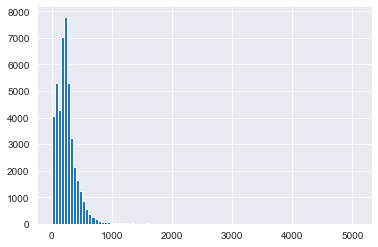

In [133]:
#padding to prepare sequences of same length. In order to decide the size of maximum length of the senteces, it is usefull to check what length our newsarticles have in general: 

plt.hist([len(x) for x in X], bins=100)
plt.show()

In [134]:
#From the graph above we can see that most texts are maximum 500 words, and a significantly lower amount of texts have 500 to 1000 words. Therefore I will take the maxlen of 750, to still include some of the outliers, but not all of them.  
maxlen = 750 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

Now all of the sentences have the same length: 750. If some sentences had less than 750 words, they have been padded with 0's. 

In [135]:
#Check the size of vocabulary. This will be the input dimension for the embedding layer of the neural network.
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

122370


Now that our data is ready to be used in the model, there is only one thing missing still: the word embeddings. 

I have chosen to use Pretrained Word Embeddings instead of using my own embeddings. The reason of this is that Pretrained word embeddings capture the semantic and syntactic meaning of a word as they are trained on large datasets. And thus they are capable of boosting the performance of a NLP model.

The Pretrained Word Embedding I will be using is Google’s Word2vec. Word2Vec is one of the most popular pretrained word embeddings developed by Google. Word2Vec is trained on the Google News dataset (about 100 billion words). Source:https:/ /www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/

In [136]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
C:\Users\Roxan/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


In [147]:
from gensim.models.keyedvectors import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('\\Users\\Roxan\\OneDrive\\Documentos\\Project_Fake_News\\Project_Fake_News\\Resources\\word2vec\\word2vec-google-news-300\\word2vec-google-news-300.gz', binary=True)

In [152]:
 # Exploring the vectors and similarity between words.
 word_vectors.most_similar('Spain')

[('Portugal', 0.7220357656478882),
 ('Inveravante_Inversiones_SL', 0.6925067901611328),
 ('Spains', 0.6856307983398438),
 ('Madrid', 0.6743447780609131),
 ('Spaniards', 0.6629219651222229),
 ('Barcelona', 0.6497775316238403),
 ('ZONAS_Europa_DIARY', 0.6474748849868774),
 ('Salave_Gold_Deposit', 0.6453762054443359),
 ('Catalonia', 0.6444673538208008),
 ('NAVAL_STATION_ROTA', 0.6433799266815186)]

In [149]:
 word_vectors.most_similar('Trump')

[('Donald_Trump', 0.8103920221328735),
 ('impersonator_entertained', 0.5942256450653076),
 ('Ivanka_Trump', 0.5924582481384277),
 ('Ivanka', 0.560720682144165),
 ('mogul_Donald_Trump', 0.5592452883720398),
 ('Trump_Tower', 0.5485552549362183),
 ('Kepcher', 0.5468589067459106),
 ('billionaire_Donald_Trump', 0.5447269678115845),
 ('Trumpster', 0.5412819981575012),
 ('tycoon_Donald_Trump', 0.5383971929550171)]

In [155]:
embedding_matrix = np.zeros((size_of_vocabulary, 300))
for word, i in  tokenizer.word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),300)

del word_vectors #Save memory

In [162]:
#deviding our data in a train and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

--------------------------------

## 5. Building model

In [158]:
#maxlen = 750
#Dimension=300

def build_compile_model():

    model = Sequential()

    model.add(Embedding(size_of_vocabulary, output_dim=300, weights=[embedding_matrix],  
    input_length=maxlen, trainable=False))

    model.add(Conv1D(activation='relu', filters=4, kernel_size=4))

    model.add(MaxPool1D())

    model.add(LSTM(units=128))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    return model

In [163]:
model = build_compile_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 750, 300)          36711000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 747, 4)            4804      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 373, 4)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               68096     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 36,784,029
Trainable params: 73,029
Non-trainable params: 36,711,000
_________________________________________________________________
None


-------------------------------

## 6. Hyperparameter Tuning and training the model

In [164]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=6)

Epoch 1/6
898/898 [==============================] - 374s 417ms/step - loss: 0.2699 - acc: 0.8937 - val_loss: 0.1202 - val_acc: 0.9575
Epoch 2/6
898/898 [==============================] - 372s 414ms/step - loss: 0.2497 - acc: 0.9002 - val_loss: 0.2605 - val_acc: 0.8999
Epoch 3/6
898/898 [==============================] - 365s 406ms/step - loss: 0.2046 - acc: 0.9208 - val_loss: 0.1768 - val_acc: 0.9333
Epoch 4/6
898/898 [==============================] - 378s 421ms/step - loss: 0.1800 - acc: 0.9309 - val_loss: 0.1175 - val_acc: 0.9580
Epoch 5/6
898/898 [==============================] - 344s 383ms/step - loss: 0.1265 - acc: 0.9545 - val_loss: 0.2311 - val_acc: 0.9141
Epoch 6/6
898/898 [==============================] - 357s 397ms/step - loss: 0.1580 - acc: 0.9391 - val_loss: 0.0874 - val_acc: 0.9705


## 7. Evaluating model


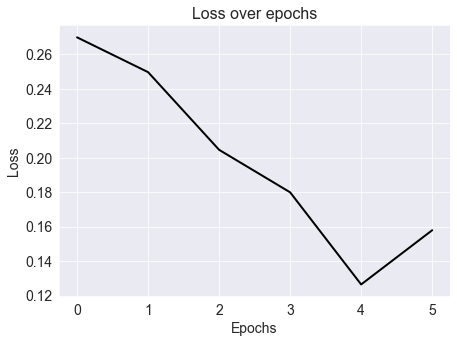

In [165]:
def show_loss(model):
    plt.figure(figsize=(7,5))
    plt.title("Loss over epochs",fontsize=16)
    plt.plot((model.history.history['loss']),c='k',lw=2)
    plt.grid(True)
    plt.xlabel("Epochs",fontsize=14)
    plt.ylabel("Loss",fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    
show_loss(model=model)

In [168]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

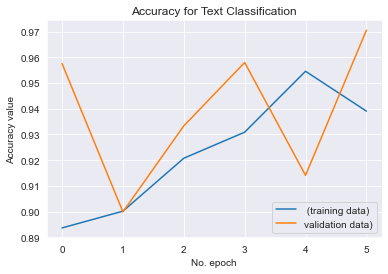

In [169]:
def train_val_accuracy(model):
    plt.plot(model.history['acc'], label=' (training data)')
    plt.plot(model.history['val_acc'], label='validation data)')
    plt.title('Accuracy for Text Classification')
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="lower right")
    plt.show()

train_val_accuracy(model=history)

In [171]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('Test loss:', test_loss)
print('\nTest accuracy:', test_acc)

281/281 - 49s - loss: 0.0852 - acc: 0.9698
Test loss: 0.08520262688398361

Test accuracy: 0.9698218107223511


## 8. Making predictions


## 9.Conclusion

In [77]:
# Word embedding is a technique where words are mapped to vectors of numbers. Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network.

EMBEDDING_DIM = 100

w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

#### Exploring the vectors and similarity between words to check if embedding was done correctly.

In [80]:
w2v_model.wv.most_similar("facebook")

[('instagram', 0.6460398435592651),
 ('gofundme', 0.642331600189209),
 ('fb', 0.6305575370788574),
 ('google', 0.6289926767349243),
 ('reddit', 0.5976168513298035),
 ('zuckerberg', 0.5723095536231995),
 ('hashtag', 0.5711944699287415),
 ('blog', 0.5667272806167603),
 ('online', 0.5661582350730896),
 ('posting', 0.5661283135414124)]

In [90]:
w2v_model.wv.most_similar(["trump", "obama"])

[('incoming', 0.5631945729255676),
 ('elect', 0.5620788335800171),
 ('cruz', 0.5089103579521179),
 ('bush', 0.4980331361293793),
 ('obamahe', 0.4924471378326416),
 ('course', 0.4706401526927948),
 ('actually', 0.4633645713329315),
 ('hillary', 0.4526031017303467),
 ('obamafeatured', 0.45020294189453125),
 ('amateur', 0.44753333926200867)]

In [84]:
w2v_model.wv.most_similar("war")

[('wars', 0.7431283593177795),
 ('ppe3fynmah', 0.5838480591773987),
 ('invasion', 0.564843475818634),
 ('conflict', 0.5618190765380859),
 ('disobedience', 0.5376485586166382),
 ('entangle', 0.53126060962677),
 ('blooded', 0.5261226892471313),
 ('wwii', 0.4998069107532501),
 ('unemotional', 0.499661386013031),
 ('salonfor', 0.475726455450058)]

In [108]:
with open("word_tensors_TSV", 'bw') as file_vector, open("word_meta_TSV", 'bw') as file_metadata:
    for word in w2v_model.wv.vocab:
        file_metadata.write((word + '\n').encode('utf-8', errors='replace'))
        vector_row = '\t'.join(str(x) for x in w2v_model[word])
        file_vector.write((vector_row + '\n').encode('utf-8', errors='replace'))

[('pavement', 0.8135626316070557), ('pedestrians', 0.805879533290863), ('truck', 0.7760772109031677), ('backpack', 0.7731896638870239), ('suv', 0.7688778638839722)]


In [ ]:
# Cleaning Special Characters and Removing Punctuations
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

In [ ]:
#Cleaning Numbers
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x